# XGBoost Classifier
## Librerias y parametros inciales

In [6]:
from lib.main_func_p1 import path, timer
import lib.main_func_p4

import numpy as np
import pandas as pd
import time
# save the models
import pickle

from collections import OrderedDict
from importlib import reload

#XGBoost library
import xgboost as xgb


#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve

In [7]:
#Escoger proteina (uniprot_ID) y el grupo al que pertenece
uniprot_id = 'P00533'
path_file = path(uniprot_id)

# Parametros
seed = 142857
fp_name = 'morgan2_c'
n_splits = 5

## Carga datos

In [8]:
df_unseen = pd.read_pickle(f'{path_file}_dataset_test')
print(f'>>> LOAD: {uniprot_id}_dataset_test')
X_unseen, y_unseen = df_unseen[fp_name].tolist(), df_unseen['activity'].tolist()

>>> LOAD: P00533_dataset_test


## Carga parámetros óptimos

In [9]:
# list values of default parameters
default_params_xgb = {'booster': 'gbtree', 'tree_method': 'gpu_hist',
                      'objective':'binary:logistic', 'eval_metric': 'auc',
                      'grow_policy': 'depthwise'}
list_dict_opt = OrderedDict([('alpha', 1.6), ('gamma', 1.5), ('lambda', 2.0), ('learning_rate', 0.2), ('max_depth', 9), ('min_child_weight', 1), ('subsample', 0.7)])

optimize_params_xgb = dict(list_dict_opt)
# Update params
optimize_params_xgb.update(default_params_xgb)
optimize_params_xgb

{'alpha': 1.6,
 'gamma': 1.5,
 'lambda': 2.0,
 'learning_rate': 0.2,
 'max_depth': 9,
 'min_child_weight': 1,
 'subsample': 0.7,
 'booster': 'gbtree',
 'tree_method': 'gpu_hist',
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'grow_policy': 'depthwise'}

## Construcción y verificación del modelo

In [10]:
reload(lib.main_func_p4)
from lib.main_func_p4 import model_clf
# xgbc model

tick = timer()
xgbc_tuned = xgb.XGBClassifier()
xgbc_tuned, df_results_model_tuned, results_ROC_fp = model_clf(xgbc_tuned, fp_name, uniprot_id,
                                                        params_dict=optimize_params_xgb, seed=seed, n_splits=n_splits,
                                                        save_log=True, resample_factor= 0, resample_mode='over_sampling')

tock = timer(tick)
df_results_model_tuned

Results XGBClassifier: 
-------------------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       711
         1.0       0.84      0.87      0.85       315

    accuracy                           0.91      1026
   macro avg       0.89      0.90      0.89      1026
weighted avg       0.91      0.91      0.91      1026

0 hours, 0 minutes, 13.8 seconds.


,Train,Test
Metric,,
AUC,0.988605,0.95481
accuracy,0.952474,0.909357
sensitivity_(recall),0.92387,0.92387
specificity,0.965165,0.926864
precision,0.921677,0.840491
f1_score,0.922772,0.854914
confusion_matrix,"[[2743, 99], [96, 1165]]","[[659, 52], [41, 274]]"


### ROC curve

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93       628
         1.0       0.84      0.83      0.83       278

    accuracy                           0.90       906
   macro avg       0.88      0.88      0.88       906
weighted avg       0.90      0.90      0.90       906



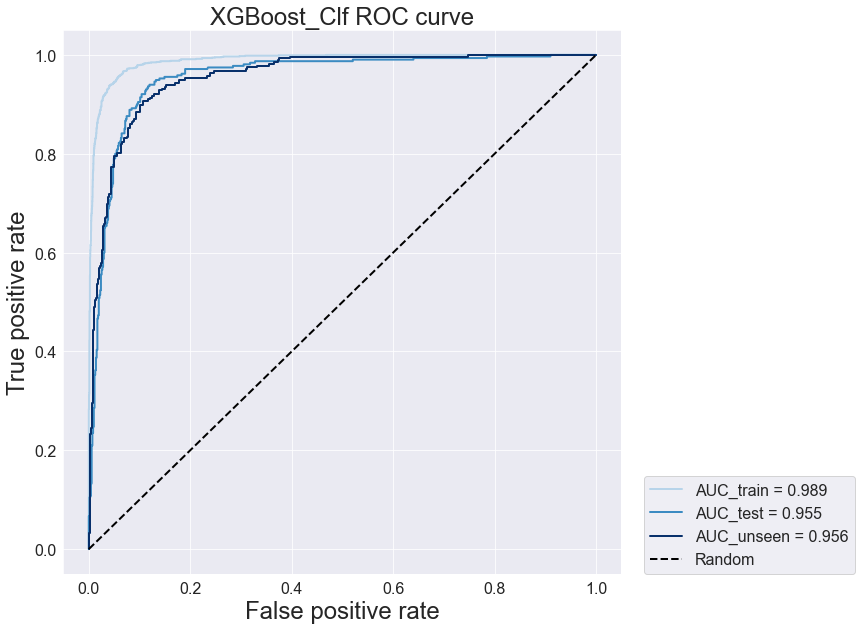

In [11]:
from lib.main_func_p4 import plot_ROC_curve
from sklearn.metrics import roc_curve, auc, classification_report

# Calcular probabilidades del conjunto de datos sin usar
pred_unseen = xgbc_tuned.predict(X_unseen)
df_unseen['prediction'] = pred_unseen

prediction_prob_unseen = np.array(xgbc_tuned.predict_proba(X_unseen)[:,1])
df_unseen['prediction_prob'] = prediction_prob_unseen


fpr_unseen, tpr_unseen, _ = roc_curve(y_unseen, prediction_prob_unseen)
auc_score_unsee = auc(fpr_unseen, tpr_unseen)
metrics_ROC_unseen = (fpr_unseen, tpr_unseen, auc_score_unsee)

model_name = f'XGBoost_Clf'
metrics_ROC = results_ROC_fp.copy()
metrics_ROC.extend([metrics_ROC_unseen])
metrics_ROC_name = ['train', 'test', 'unseen']

print(classification_report(y_unseen, pred_unseen))
plot_ROC_curve(metrics_ROC, metrics_ROC_name, model_name, path_file=path_file, save_fig=True)

### Calibration curve

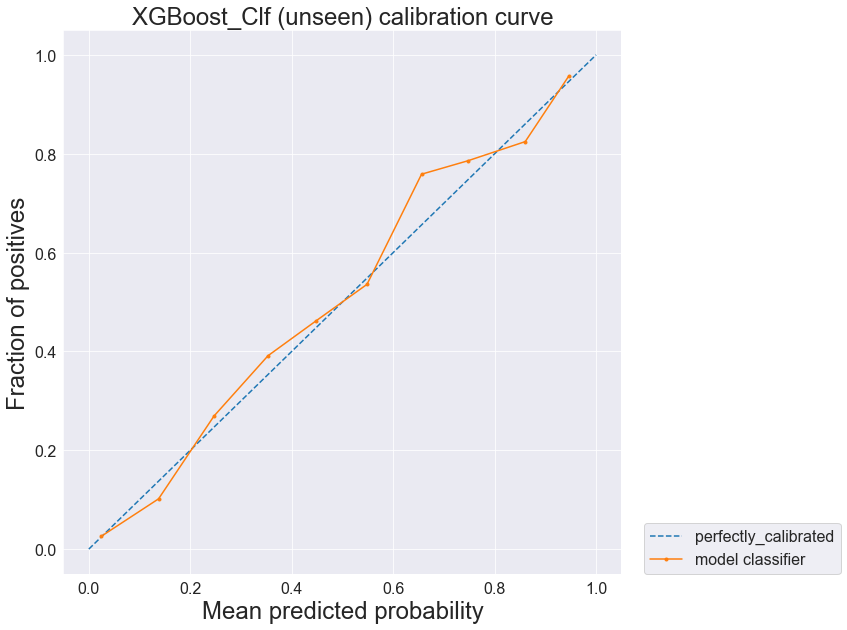

In [12]:
from lib.main_func_p4 import plot_calibration_curve

# TODO: medir hyperparámetros r^2
model_name = f'XGBoost_Clf (unseen)'
plot_calibration_curve(df_unseen, model_name, path_file=path_file, save_fig=True)

### Guardar y exportar el modelo
El modelo elegido se va a exportar y a utilizar con un conjunto de decoys y el conjunto de test.

In [13]:
with open(f'{path_file}_XGBoost_{fp_name}_model', 'wb') as f:
    pickle.dump(xgbc_tuned, f)
print(f'{uniprot_id}_XGBoost_{fp_name}_model SAVED')

P00533_XGBoost_morgan2_c_model SAVED


## Uso del modelo

### Carga del modelo

Cargar el modelo de Random Forest entrenado en el paso anterior.
Imprimir los hyper parámentros

In [32]:
with open(f'{path_file}_XGBoost_{fp_name}_model', 'rb') as f:
    xgbc_tuned = pickle.load(f)
print(f'{uniprot_id}_XGBoost_{fp_name}_model LOAD')
print('Hyper parámetros : \n', xgbc_tuned.get_params())

P00533_XGBoost_morgan2_c_model LOAD
Hyper parámetros : 
 {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'auc', 'gamma': 1.5, 'gpu_id': 0, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.2, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 9, 'max_leaves': 0, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 1.60000002, 'reg_lambda': 2, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'alpha': 1.6, 'lambda': 2.0}


### Carga del conjunto de prueba

In [33]:
from lib.main_func_p4 import resampling_set
print(f'Datos iniciales: {df_unseen.shape}')
print('Submuestreo 1:1')
# resample 1:1
df_unseen_rsmpl = resampling_set(df_unseen, mode='under_sampling', ratio=1)

df_unseen_rsmpl['type'] = 'unseen_inactive'
df_unseen_rsmpl.loc[df_unseen_rsmpl[df_unseen_rsmpl.activity == 1.0].index, 'type'] = 'unseen_active'
df_unseen_rsmpl.reset_index(drop=True, inplace=True)

df_unseen_rsmpl = df_unseen_rsmpl[['type', fp_name, 'activity', 'prediction', 'prediction_prob']]
print(df_unseen_rsmpl.shape)
print(df_unseen_rsmpl.activity.value_counts())
df_unseen_rsmpl.head()

Datos iniciales: (906, 5)
Submuestreo 1:1
(556, 5)
1.0    278
0.0    278
Name: activity, dtype: int64


,type,morgan2_c,activity,prediction,prediction_prob
0,unseen_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.971569
1,unseen_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.178258
2,unseen_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1.0,1,0.682923
3,unseen_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.012911
4,unseen_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1.0,0,0.138833


### Carga y preparación de los decoys
El archivo {uniprot_id}_all_smiles.ism contiene la lista de decoys del target.
Se carga el archivo y se convierte en un data set, por ahora solo contiene el SMILE.
Se escoge aleatoriamente una muestra con la misma cantidad de compuestos activos / inactivos (1:1:1)

In [34]:
df_decoys = pd.DataFrame(columns=['smiles'])
list_d = list()
decoys_len = int(len(df_unseen)/2)
with open(f'data/_decoys/{uniprot_id}_all_smiles.ism', 'rb') as f:
    decoys_line = f.readlines()
    for line in decoys_line[1:]: #la primera linea es header
        line = line.decode('UTF-8').split()
        list_d.append(line)
df_decoys = pd.DataFrame(list_d, columns=['smiles', 'id'])

print(f'Decoys iniciales: {df_decoys.shape}')
# OPC 1: Escoger una cantidad igual al conjunto de prueba
df_decoys = df_decoys.sample(n=decoys_len, ignore_index=True, random_state=seed)

# OPC 2: Trabajar con un porcentaje
# df_decoys = df_decoys.sample(frac=0.5, ignore_index=True, random_state=seed)

print(f'Decoys conjunto muestra: {len(df_decoys)}')
df_decoys.head()

Decoys iniciales: (35050, 2)
Decoys conjunto muestra: 453


,smiles,id
0,CCN(c1ccccc1)C(=O)c2c(c\3c(o2)CCC/C3=N\NC(=O)C...,C40826754
1,Cc1c(sc(n1)N2[C@H](c3c(=O)c4cc(ccc4oc3C2=O)Cl)...,C35514101
2,C1CCC(C1)(CNC(=O)N2CCC(CC2)C(=O)NC3CC3)[NH+]4C...,C56878242
3,C[C@H]1CCCC[C@@H]1NC(=O)CSc2nnc3n2c4ccccc4c(=O...,C10058402
4,CCC[NH+](Cc1ncc(o1)c2cccs2)CC3CC3,C67427773


Encontrar el fingerprint de cada decoy a partir del SMILE.

In [35]:
reload(lib.main_func_p3)
from lib.main_func_p3 import calculate_onefp

calculate_onefp(df_decoys, fp_name)
df_decoys.drop_duplicates(subset=['smiles'], inplace=True)
df_decoys.reset_index(inplace=True, drop=True)
df_decoys = df_decoys.drop(['mol'], axis=1)
df_decoys = df_decoys.drop(['smiles'], axis=1)
df_decoys['type'] = 'decoy'
df_decoys = df_decoys[['type', fp_name]]
df_decoys.head()

,type,morgan2_c
0,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,decoy,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,decoy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


### Predicciones

Con el modelo cargado, clasificar cada compuesto del conjunto decoys en activo: 1.0 o inactivo 0.0

In [36]:
x_decoy = df_decoys[fp_name].tolist()
pred_decoy = xgbc_tuned.predict(x_decoy)
prediction_prob = xgbc_tuned.predict_proba(x_decoy)[:,1]
prediction_prob = np.array(prediction_prob)
df_decoys['activity'] = 0.0
df_decoys['prediction'] = pred_decoy
df_decoys['prediction_prob'] = prediction_prob
df_decoys.prediction.value_counts()

0    453
Name: prediction, dtype: int64

In [37]:
df = pd.concat([df_unseen_rsmpl, df_decoys], ignore_index=True)
print(df.type.value_counts())
df.head()

decoy              453
unseen_active      278
unseen_inactive    278
Name: type, dtype: int64


,type,morgan2_c,activity,prediction,prediction_prob
0,unseen_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,1,0.971569
1,unseen_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.178258
2,unseen_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1.0,1,0.682923
3,unseen_inactive,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0,0.012911
4,unseen_active,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1.0,0,0.138833


<Figure size 1080x1080 with 0 Axes>

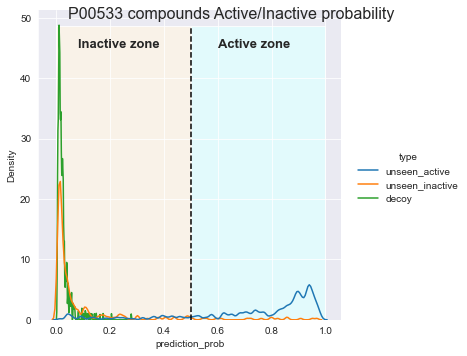

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
fig.set_size_inches(15,15)
ax = sns.displot(data=df, x='prediction_prob', hue="type", kind="kde", bw_adjust=.1, common_norm=False, hue_order=['unseen_active', 'unseen_inactive', 'decoy'])

plt.axvline(x=0.5, ymax=0.95, color='k', linestyle='--')
plt.axvspan(0, 0.5, ymax=0.95, facecolor='oldlace', alpha=0.8, zorder=-100)
plt.axvspan(0.5, 1, ymax=0.95, facecolor='lightcyan', alpha=0.8, zorder=-100)

plt.text(0.08, 0.88* plt.gca().get_ylim()[1], 'Inactive zone', fontsize=13, fontdict={"weight": "bold"})
plt.text(0.6, 0.88* plt.gca().get_ylim()[1], 'Active zone', fontsize=13, fontdict={"weight": "bold"})
plt.suptitle(f'{uniprot_id} compounds Active/Inactive probability',
                  fontsize=16, fontdict={"weight": "bold"})
plt.savefig(f'{path_file}_compounds_prob.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from lib.main_func_p4 import plot_calibration_curve

# TODO: medir hyperparámetros r^2
model_name = f'XGBoost_Clf (unseen)'
plot_calibration_curve(df, model_name, path_file=path_file, save_fig=False)

In [ ]:
from sklearn import metrics
print(sorted(metrics.SCORERS.keys()))

## Intermediate

In [26]:
ADME_df = pd.read_csv(f'{path_file}_02_ligands_smiles_ADME_lipinski.csv')
df_int = ADME_df[ADME_df['activity_type']=='Intermediate']
df_int = df_int[['chembl_id_ligand', 'smiles']]
df_int.reset_index(drop=True, inplace=True)
print(f'No. intermediate compounds: {len(df_int)}')

No. intermediate compounds: 1282


In [27]:
from lib.main_func_p3 import calculate_onefp

calculate_onefp(df_int, fp_name)
df_int.drop_duplicates(subset=['smiles'], inplace=True)
df_int.reset_index(inplace=True, drop=True)
df_int = df_int.drop(['mol'], axis=1)
df_int = df_int.drop(['smiles'], axis=1)
df_int['type'] = 'intermediate'
df_int = df_int[['type', fp_name]]
df_int.head()

,type,morgan2_c
0,intermediate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,intermediate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,intermediate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,intermediate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,intermediate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Predicciones

In [30]:
x_inter = df_int[fp_name].tolist()
pred_inter = xgbc_tuned.predict(x_inter)
prediction_prob = xgbc_tuned.predict_proba(x_inter)[:,1]
prediction_prob = np.array(prediction_prob)
df_int['activity'] = 0.0
df_int['prediction'] = pred_inter
df_int['prediction_prob'] = prediction_prob
df_int.prediction.value_counts()

0    652
1    630
Name: prediction, dtype: int64

<Figure size 1080x1080 with 0 Axes>

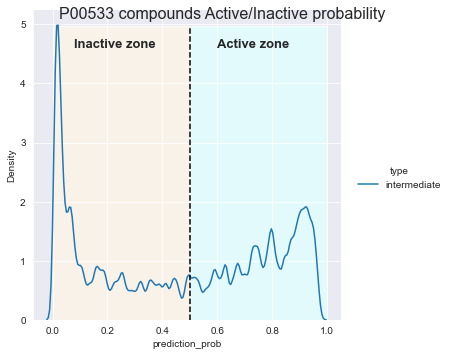

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
fig.set_size_inches(15,15)
ax = sns.displot(data=df_int, x='prediction_prob', hue="type", kind="kde", bw_adjust=.1, common_norm=False)

plt.axvline(x=0.5, ymax=0.95, color='k', linestyle='--')
plt.axvspan(0, 0.5, ymax=0.95, facecolor='oldlace', alpha=0.8, zorder=-100)
plt.axvspan(0.5, 1, ymax=0.95, facecolor='lightcyan', alpha=0.8, zorder=-100)

plt.text(0.08, 0.88* plt.gca().get_ylim()[1], 'Inactive zone', fontsize=13, fontdict={"weight": "bold"})
plt.text(0.6, 0.88* plt.gca().get_ylim()[1], 'Active zone', fontsize=13, fontdict={"weight": "bold"})
plt.suptitle(f'{uniprot_id} compounds Active/Inactive probability',
                  fontsize=16, fontdict={"weight": "bold"})
plt.savefig(f'{path_file}_compounds_prob.png', dpi=300, bbox_inches='tight')
plt.show()